In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import torch.nn as nn
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import random
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import shutil
import sys

from torchinfo import summary
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import KFold
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from tqdm import tqdm
from collections import Counter
from PIL import Image
from pathlib import Path
import plotly.express as px
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as T

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# sys.path.append('/kaggle/input/helper_functions/pytorch/default/1')


import importlib
import helper_functions
importlib.reload(helper_functions)
from helper_functions import plot_random_images, predict, train, score

In [138]:
# data_dir = Path('/kaggle/input/cassava-dataset')
full_data_dir = Path('/kaggle/input/full-cassava-dataset/train/train')
under_data_dir = Path('/kaggle/input/cassava-dataset/kaggle_dataset/undersampled')
# train_dir= Path('/kaggle/input/cassava-dataset/kaggle_dataset/undersampled')
val_dir = Path('/kaggle/input/cassava-dataset/kaggle_dataset/test')
# train_dir.exists(), val_dir.exists(), data_dir.exists()



class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img
    
# train_transforms = transforms.Compose([ConvertToRGB(), transforms.Resize((224, 224)), transforms.RandomResizedCrop(224),
#                                     transforms.RandomHorizontalFlip(p=0.5),   transforms.RandomVerticalFlip(p=0.5),    
#                                     transforms.RandomRotation(degrees=20),    transforms.ColorJitter(brightness=0.2, saturation=0.2, hue=0.1), 
#                                     transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# val_transforms = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(), 
#                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# efficient_net_trans = transforms.Compose([
#         transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), 
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#                                             ])

train_transforms = T.Compose([T.Resize((320, 320)), T.RandomResizedCrop(300, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

val_transforms = T.Compose([T.Resize((320, 320)), T.ToTensor()])


full_dataset = ImageFolder(full_data_dir, transform= train_transforms) #train_transforms)
under_dataset = ImageFolder(under_data_dir, transform=train_transforms)
val_dataset = ImageFolder(val_dir, transform= val_transforms) #val_transforms)
full_train_dataset, full_test_dataset = random_split(full_dataset, [.8, .2])
under_train_dataset, under_test_dataset = random_split(under_dataset, [.8, .2])


full_train_dataloader = DataLoader(full_train_dataset, batch_size=32, shuffle=True)
full_test_dataloader = DataLoader(full_test_dataset, shuffle=False, batch_size=32)
under_train_dataloader = DataLoader(under_train_dataset, batch_size=32, shuffle=True)
under_test_dataloader = DataLoader(under_test_dataset, shuffle=False, batch_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

class_names  = full_dataset.classes
class_indexes = full_dataset.class_to_idx
num_classes = len(class_names)
print(class_names)

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']


In [249]:
# [len(os.listdir(os.path.join(train_dir, i))) for i in classes]
class_dir_dict = {}
for i in class_names:
    class_dir_dict[i] = len(list((full_data_dir/i).iterdir()))
class_dir_dict = pd.Series(class_dir_dict).rename('class')
fig = px.bar(class_dir_dict, x=class_dir_dict.values, y=class_dir_dict.index)
fig.update_layout(xaxis_title='Count', yaxis_title='Disease', title='Dataset Distribution')
fig.show()

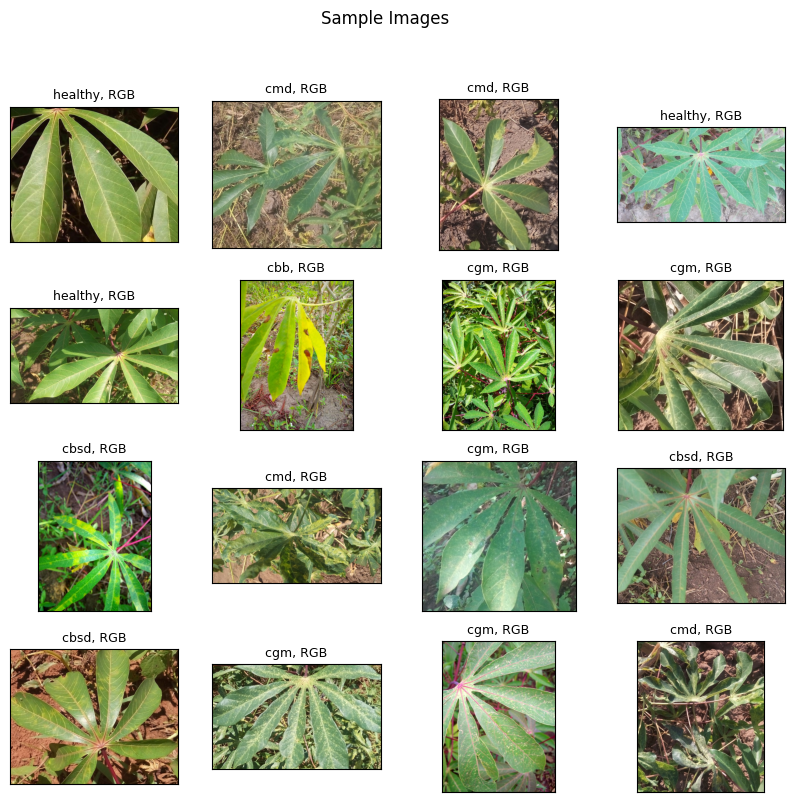

In [59]:
plot_random_images(full_data_dir, classes=class_names, nrows=4, ncols=4)

In [15]:
# model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = models.efficientnet_b3(weights="IMAGENET1K_V1")
final_layer  = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 256),
    nn.ReLU(),
    nn.Dropout(p=.2),
    nn.Linear(256, num_classes))

for param in model.parameters():
    param.requires_grad = False

# # unfreeze last 2 blocks
# for param in model.features[-2:].parameters():
#     param.requires_grad = True
    
model.classifier = final_layer
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=.0001)
loss_fn = nn.CrossEntropyLoss()


In [16]:
full_dataset_results = train(model, optimizer, loss_fn, under_train_dataloader, under_test_dataloader, epochs=10, device=device)

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 0.95
    Training accuracy: 0.66
    Validation loss: 0.97
    Validation accuracy: 0.65


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 0.79
    Training accuracy: 0.72
    Validation loss: 0.82
    Validation accuracy: 0.70


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.73
    Training accuracy: 0.75
    Validation loss: 0.75
    Validation accuracy: 0.74


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.66
    Training accuracy: 0.78
    Validation loss: 0.69
    Validation accuracy: 0.76


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.62
    Training accuracy: 0.79
    Validation loss: 0.65
    Validation accuracy: 0.78


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.60
    Training accuracy: 0.79
    Validation loss: 0.64
    Validation accuracy: 0.77


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 7
    Training loss: 0.58
    Training accuracy: 0.80
    Validation loss: 0.62
    Validation accuracy: 0.79


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 8
    Training loss: 0.57
    Training accuracy: 0.81
    Validation loss: 0.61
    Validation accuracy: 0.80


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 9
    Training loss: 0.55
    Training accuracy: 0.81
    Validation loss: 0.60
    Validation accuracy: 0.81


Training:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/142 [00:00<?, ?it/s]

Scoring:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 10
    Training loss: 0.55
    Training accuracy: 0.81
    Validation loss: 0.61
    Validation accuracy: 0.79


In [247]:
torch.save(model.state_dict(), 'cassava_disease_model1.pth')

In [36]:
train_losses, val_losses, train_accuracies, val_accuracies = full_dataset_results
model_results_df = pd.DataFrame({'Train Loss': train_losses, 'Validation Loss': val_losses, 
              'Train Accuracy': train_accuracies, 'Validation Accuracy': val_accuracies})
# model_results_df[['Train Accuracy', 'Validation Accuracy']].plot()
fig = px.line(model_results_df[['Train Accuracy', 'Validation Accuracy']])
fig.update_layout(xaxis_title='Epochs', yaxis_title='Accuracy', title='Model Accuracies')

In [38]:
fig = px.line(model_results_df[['Train Loss', 'Validation Loss']])
fig.update_layout(xaxis_title='Epochs', yaxis_title='Accuracy', title='Model Loss')

In [245]:
def make_predictions(number_of_images=30):
    correct = 0
    random_idx = random.sample(range(len(test_dataset)), number_of_images)
    preds, actual_labels, all_images = [], [], []
    for idx in random_idx:
        random_img, random_label = test_dataset[idx]
        all_images.append(random_img)
        random_img = random_img.to(device)
        with torch.no_grad():
            output = model(random_img.unsqueeze(0))
            pred = output.argmax().item()
            predicted_label = class_names[pred]
            actual_label = class_names[random_label]
            preds.append(predicted_label)
            actual_labels.append(actual_label)
            if predicted_label == actual_label:
                correct+=1
            # print(predicted_label,actual_label)
    print(correct/number_of_images)
    
    def unnormalize(img, mean= [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        mean = torch.tensor(mean).view(1, 1, -1)
        std = torch.tensor(std).view(1, 1, -1)
        return img.permute(1, 2, 0) * std + mean
        
    all_images_normalized = [unnormalize(img).permute(2,0,1) for img in all_images]
    
    fig, ax = plt.subplots(figsize=(10,13), nrows=math.ceil(number_of_images/5), ncols=5)
    fig.tight_layout()
    ax = ax.flatten()
    for i, axis in enumerate(ax):
        # axis.set_xlim(100, 1000)
        axis.imshow(to_pil_image(all_images_normalized[i]))
        color = 'green' if preds[i] == actual_labels[i] else 'red'
        axis.set_title(f'Actual: {actual_labels[i]}\n Pred:{preds[i]}', fontsize=12, color=color)
        axis.axis('off')

0.8


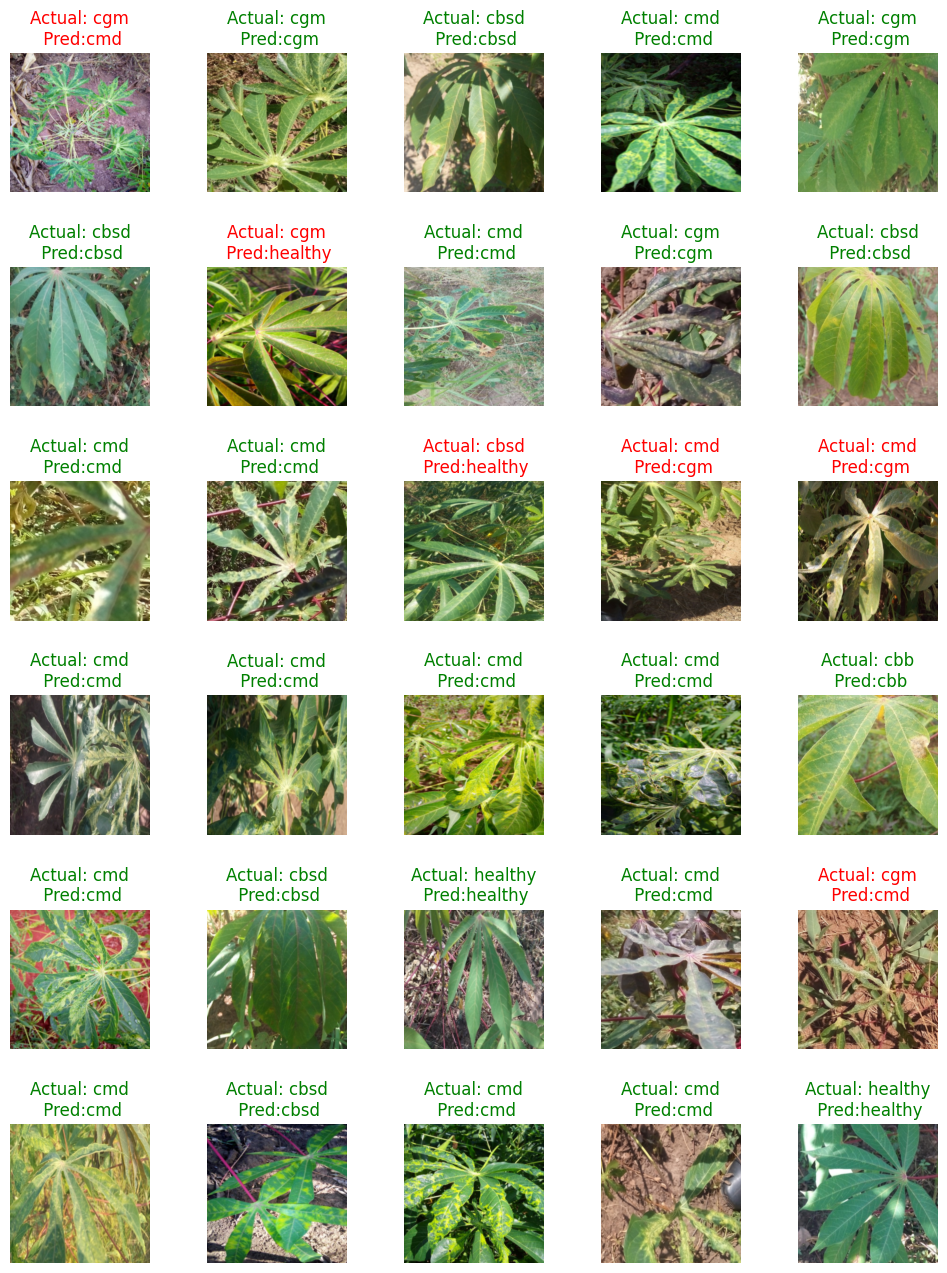

In [248]:
make_predictions(30)